In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from copy import *

### System information: 

- nominal MPC (e.g. no noise or disturbances in process.)
- OCP: double integrator model
    - discrete-time system, linear model
    - wish to solve minimization s.t. u,x in the form:
        - $\min_{x, u} x_{N}^{\top}Q_{N}x_{N} + \sum_{k=0}^{N-1} x_{k}^{\top}Qx_{k}+u_{k}^{\top}Ru_{k}$
        - s.t.:
            - $|u_{k}| \leq 1 \quad \quad \forall_k = 0, 1,...,N-1$
            - $|y_{k}| \leq 1 \quad \quad \forall_k = 0, 1,...,N-1$
        - $x(i+1) = A x(i) + B u(i)$
        - $y(i) = C x(i)$
    - prediction horizon: $\quad 10$
    - terminal cost: $\qquad \quad x_{N}^{\top}Q_{N}x_{N}$
    - stage cost: $\qquad \qquad \sum_{k=0}^{N-1} x_{k}^{\top}Rx_{k}+u_{k}^{\top}Su_{k}$
- using off-the-shelf packages, CasADi functions to formulate the problem, Opti to solve

### CONSTRUCT SOLVER

In [2]:
x_states = 2 # total number of states
x = SX.sym('x', x_states) # symbol for states

u_controls = 1 # total number of control inputs
u = SX.sym('u', u_controls) # symbol for control inputs

y_outputs = 2 # total number of outputs
y = SX.sym('y', y_outputs) # symbol for control inputs

pred_hori = 10

a = 0.75


Defining matrices

In [3]:
A, B, C = np.array([[1, 1], [0,1]]), np.array([[0.5], [1.0]]), np.array([[1, 0], [0, 1]])

Defining evolution equations

In [4]:
f = Function('f', [x, u], [(A@x + B@u)]) # dynamics, e.g. state evolution, [name, input, output]
g = Function('g', [x], [(C@x)]) # output evolution 

Defining cost functions

In [5]:
Q, R, S = np.eye(x_states), np.eye(u_controls), np.eye(x_states) # weight factors
stage_cost = Function('stage_cost', [x, u], [(x.T@Q@x) + (u.T@R@u)])
terminal_cost = Function('terminal_cost', [x], [x.T@S@x])

Defining constraints and initial values of the decision variables

In [6]:
U_bound, Y_bound = 1., 1.
u_min, u_max = -U_bound * np.ones((u_controls, 1)), U_bound * np.ones((u_controls, 1))
y_min, y_max = -Y_bound * np.ones((y_outputs, 1)), Y_bound * np.ones((y_outputs, 1))

x_init, u_init, y_init = np.zeros(x_states), np.zeros(u_controls), np.zeros(y_outputs)

In [7]:
opti = Opti()

In [8]:
# defining containers
X, U, Y = [0 for _ in range(pred_hori + 1)], [0 for _ in range(pred_hori)], [0 for _ in range(pred_hori + 1)] # tracking decision variables
J = 0 # initialize cost/objective

In [9]:
initial_state = np.array([-0.75, 0.75]).reshape(-1, 1)

In [10]:
X[0], Y[0] = opti.parameter(x_states), opti.variable(y_outputs)
opti.set_value(X[0], initial_state) # afix known initial state e.g. k = 1
opti.subject_to(Y[0] == g(X[0])) # afix initial output decision variable e.g. k = 1

In [11]:
for k in range(pred_hori):    
    # Control input U
    U[k] = opti.variable(u_controls) # control input @ step k
    opti.set_initial(U[k], u_init) # initialize control input                                                            
    opti.subject_to(opti.bounded(u_min, U[k], u_max)) # constraints on control input
    
    # increment stage cost
    J += stage_cost(X[k], U[k])

    # State X
    X[k + 1] = opti.variable(x_states) # state @ step k + 1
    opti.set_initial(X[k + 1], x_init) # initialize state at k + 1
    
    # Output Y
    Y[k + 1] = opti.variable(y_outputs) # output @ step k + 1
    opti.set_initial(Y[k + 1], y_init) # initialize output at k + 1
    opti.subject_to(opti.bounded(y_min, Y[k + 1], y_max)) # constraints on output 

    # constraints on dynamics and output equations
    opti.subject_to(X[k + 1] == f(X[k], U[k]))
    opti.subject_to(Y[k + 1] == g(X[k + 1]))

Terminate cost

In [12]:
J += terminal_cost(X[-1]) # indexed for the last state

Minimize the cost

In [13]:
opti.minimize(J)

### SOLVE

#### [Ipopt](https://coin-or.github.io/Ipopt/): Input solver options, then solve.

In [14]:
p_opts = {'verbose': False, 'expand': True, 'print_time': 1} # options taken from K.C. --> Ipopt options to print to console
s_opts = {'max_iter': 1000, 'print_level': 1, 'tol': 1e-6}

opti.solver('ipopt', p_opts, s_opts)

soln = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 163.00us ( 27.17us)  20.83us (  3.47us)         6
       nlp_g  | 238.00us ( 39.67us)  29.70us (  4.95us)         6
  nlp_grad_f  | 228.00us ( 32.57us)  29.01us (  4.14us)         7
  nlp_hess_l  | 124.00us ( 24.80us)  16.99us (  3.40us)         5
   nlp_jac_g  | 243.00us ( 34.71us)  32.24us (  4.61us)         7
       total  |  79.93ms ( 79.93ms)  10.45ms ( 10.45ms)         1


In [15]:
# defining prediction values
U_soln = np.array([soln.value(u) for u in U]).reshape(-1, u_controls).T
X_soln = np.array([soln.value(x) for x in X]).reshape(-1, x_states).T
Y_soln = np.array([soln.value(y) for y in Y]).reshape(-1, y_outputs).T

### SIMULATE

In [16]:
# Open-loop
# Construct containers
X_ol_sim = np.zeros((x_states, pred_hori + 1))
Y_ol_sim = np.zeros((y_outputs, pred_hori + 1))

# Set initial state
X_ol_sim[:, 0] = np.ravel(initial_state)
Y_ol_sim[:, 0] = np.ravel(g(X_ol_sim[:, 0]).full())

In [17]:
# simulate
U_ol_soln = deepcopy(U_soln)
for k in range(pred_hori):
    # feed in each predicted controller input value
    X_ol_sim[:, k + 1] = np.ravel(f(a*X_ol_sim[:, k], U_ol_soln[:, k]).full())
    Y_ol_sim[:, k + 1] = np.ravel(g(X_ol_sim[:, k]).full())

No noise

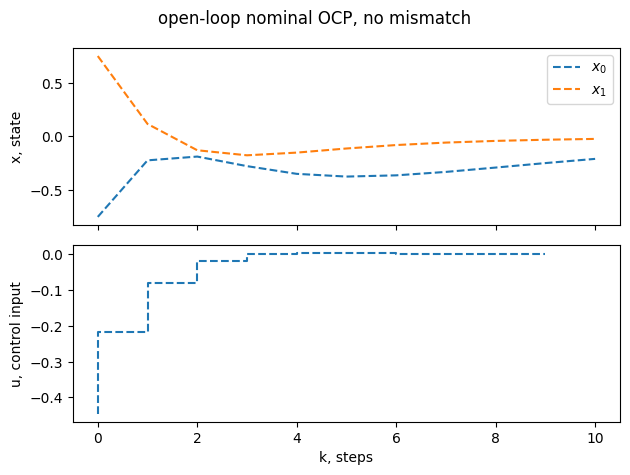

In [18]:
# plot u, x on same x-axis (steps)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# X
for j in range(X_ol_sim.shape[0]):
    ax1.plot(X_ol_sim[j, :], '--', label=f'$x_{j}$')
if j > 0:
    ax1.legend()
ax1.set_ylabel('x, state')

# U --> step() as this is your controller knob
for i in range(U_soln.shape[0]):
    ax2.step(U_soln[i, :], '--', label=f'$u_{i}$')
if i > 0:
    ax2.legend()
ax2.set_ylabel('u, control input')
fig.suptitle('open-loop nominal OCP, no mismatch')
ax2.set_xlabel('k, steps')

plt.tight_layout()

In [19]:
# Close the loop

In [20]:
# defining containers
sim_hori = 10
X_cl_sim = np.zeros((x_states, sim_hori + 1)) # state evolution
Y_cl_sim = np.zeros((y_outputs, sim_hori + 1)) # output evolution
U_cl_sim = np.zeros((u_controls, sim_hori)) # input evolution

J = 0 # reset cost

In [21]:
X_cl_sim[:,0] = np.ravel(initial_state) # set the initial state
Y_cl_sim[:,0] = np.ravel(g(X_cl_sim[:,0]).full())

##### Closed-loop solve

In [22]:
for k in range(sim_hori):
    opti.set_value(X[0], X_cl_sim[:, k])
    sol = opti.solve()
    U_soln = np.array([sol.value(u) for u in U]).reshape(u_controls, -1)
    Y_soln = np.array([sol.value(y) for y in Y]).reshape(u_controls, -1)
    
    U_cl_sim[:, k] = U_soln[:, 0] # only interested in first optimal input in control

    X_cl_sim[:, k + 1] = np.ravel(f(a*X_cl_sim[:, k], U_cl_sim[:, k]).full()) # apply input to plant
    Y_cl_sim[:, k + 1] = np.ravel(g(X_cl_sim[:, k + 1]).full())

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 174.00us ( 14.50us)  32.69us (  2.72us)        12
       nlp_g  | 261.00us ( 21.75us)  47.42us (  3.95us)        12
    nlp_grad  |  29.00us ( 29.00us)   4.34us (  4.34us)         1
  nlp_grad_f  | 247.00us ( 17.64us)  47.07us (  3.36us)        14
  nlp_hess_l  | 134.00us ( 13.40us)  25.84us (  2.58us)        10
   nlp_jac_g  | 258.00us ( 18.43us)  49.14us (  3.51us)        14
       total  |   4.96ms (  4.96ms)   4.94ms (  4.94ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 185.00us ( 10.28us)  44.50us (  2.47us)        18
       nlp_g  | 285.00us ( 15.83us)  65.18us (  3.62us)        18
    nlp_grad  |  33.00us ( 16.50us)   8.15us (  4.08us)         2
  nlp_grad_f  | 266.00us ( 12.67us)  62.39us (  2.97us)        21
  nlp_hess_l  | 144.00us (  9.60us)  34.98us (  2.33us)        15
   nlp_jac_g  | 277.00us ( 13.19us)  65.33us (  3.11us)        21
       tot

In [23]:
U_cl_sim

array([[-4.45486988e-01, -2.35655853e-02, -2.64485028e-02,
        -7.80774732e-03, -3.19991938e-03, -1.17223334e-03,
        -4.45024726e-04, -1.66993312e-04, -6.28998874e-05,
        -2.36630043e-05]])

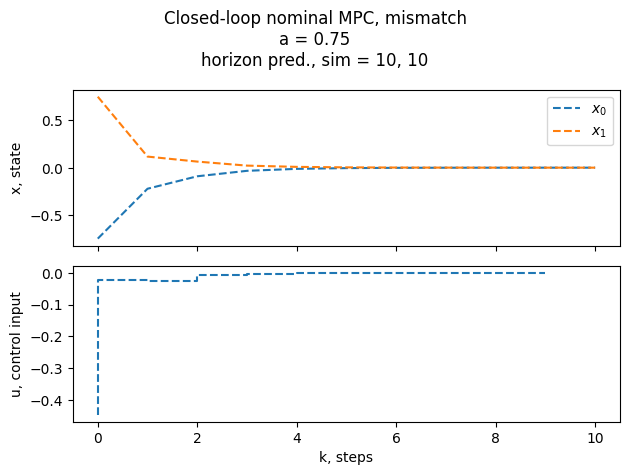

In [24]:
# plot u, x on same x-axis (steps)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# X
for i in range(X_cl_sim.shape[0]):
    ax1.plot(X_cl_sim[i, :], '--', label=f'$x_{i}$')
ax1.legend()
ax1.set_ylabel('x, state')

# U --> step() as this is your controller knob
ax2.step(np.arange(U_cl_sim.shape[1]),np.ravel(U_cl_sim), '--') 
ax2.set_ylabel('u, control input')

ax2.set_xlabel('k, steps')
fig.suptitle('Closed-loop nominal MPC, mismatch\n'+ 'a = ' + str(a) + '\n' 
             + 'horizon pred., sim = ' + str(pred_hori) + ', ' + str(sim_hori))
plt.tight_layout()

### Plotting match and mismatch

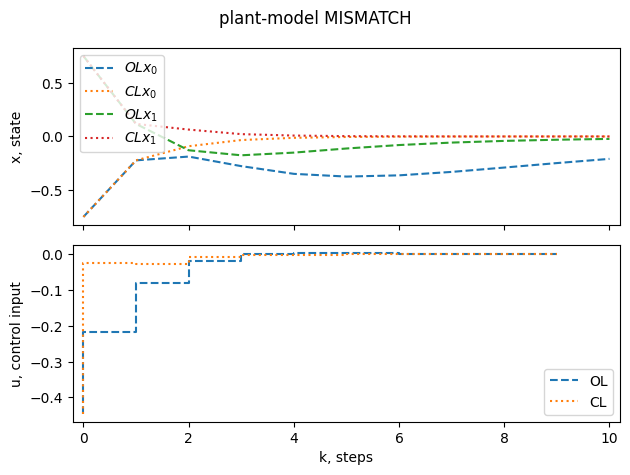

In [25]:
# no noise, match plant-model
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# X
for i in range(2):
    ax1.plot(X_ol_sim[i, :], '--', label=f'$OL x_{i}$')
    ax1.plot(X_cl_sim[i, :], ':', label=f'$CL x_{i}$')
ax1.legend()
ax1.set_ylabel('x, state')

# U --> step() as this is your controller knob
ax2.step(np.arange(U_ol_soln .shape[1]),np.ravel(U_ol_soln ), '--', label='OL') 
ax2.step(np.arange(U_cl_sim.shape[1]),np.ravel(U_cl_sim), ':', label='CL') 
ax2.legend()
ax2.set_ylabel('u, control input')

ax2.set_xlabel('k, steps')

fig.suptitle('plant-model MISMATCH')
ax1.set_xlim(-0.2, 10.2)
plt.tight_layout()
# (CL_X OL_X) (CL_U OL_U)